In [1]:
!gdown 1jl1xuw514vW7gVxg6cyWED3Vv6QrIzwF

Downloading...
From: https://drive.google.com/uc?id=1jl1xuw514vW7gVxg6cyWED3Vv6QrIzwF
To: /content/spam_text_message.csv
100% 480k/480k [00:00<00:00, 99.6MB/s]


In [2]:
! pip install transformers[torch] datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.0 MB/s eta 0:00:00


#Податочно множество
Симнете го датасетот од линкот кој ви е поставен на самата задача, потоа истиот поставете го локално за да го вчитате.
Во случај на грешка при вчитување на .csv додадете аргумент `encoding='latin-1`


In [3]:
import pandas as pd
from datasets import load_dataset

In [4]:
data = pd.read_csv('/content/spam_text_message.csv')
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [6]:
dataset = load_dataset("csv", data_files='/content/spam_text_message.csv')
dataset

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Category', 'Message'],
        num_rows: 5572
    })
})

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
encoder = LabelEncoder()

In [9]:
dataset['train'] = dataset['train'].add_column('label', encoder.fit_transform(dataset['train']['Category']))

In [10]:
dataset['train'] = dataset['train'].remove_columns('Category')

In [11]:
dataset['train']

Dataset({
    features: ['Message', 'label'],
    num_rows: 5572
})

In [12]:
dataset = dataset['train'].train_test_split(test_size=0.2)

In [13]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def tokenize_function(examples):
    return tokenizer(examples["Message"], padding="max_length", truncation=True)

In [15]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/4457 [00:00<?, ? examples/s]

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

In [16]:
import numpy as np
import evaluate

metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [17]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,  # batch size for training
    per_device_eval_batch_size=8,  # batch size for evaluation
    metric_for_best_model="f1",
    learning_rate=5e-5
)

In [18]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['Message', 'label', 'input_ids', 'attention_mask'],
        num_rows: 4457
    })
    test: Dataset({
        features: ['Message', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1115
    })
})

In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
)

In [20]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
trainer.evaluate()

In [ ]:
predictions = trainer.predict(tokenized_datasets['test'])

In [ ]:
predictions

In [ ]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)

In [ ]:
preds

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
print(classification_report(labels, preds))

In [ ]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt='5.2f')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title('Confusion matrix')

In [ ]:
Text(0.5, 1.0, 'Confusion matrix')

#MODEL NEVRONSKA MREZHA


In [323]:
data = pd.read_csv('/content/spam_text_message.csv')
data

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [324]:
data.isna().sum()

Category    0
Message     0
dtype: int64

In [325]:
data.groupby('Category').count()

,Message
Category,
ham,4825
spam,747


In [326]:
data['text_length'] = data['Message'].apply(len)

<Axes: ylabel='Frequency'>

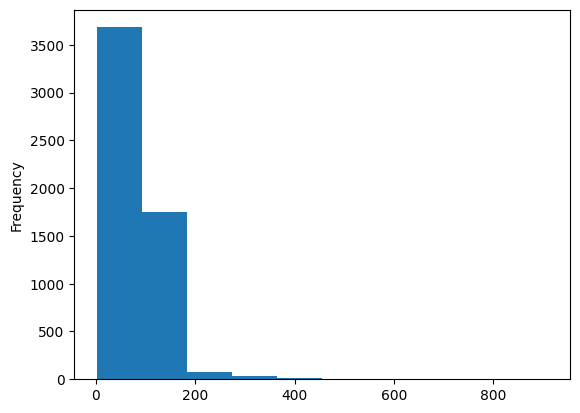

In [327]:
data['text_length'].plot.hist()

In [328]:
X = data['Message']
Y = pd.get_dummies(data['Category'])

In [329]:
Y.values

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [330]:
num_classes = len(Y.columns)
num_classes

2

In [331]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [332]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [333]:
data['num_words'] = data['Message'].apply(lambda x: len(x.split(" ")))

<Axes: ylabel='Frequency'>

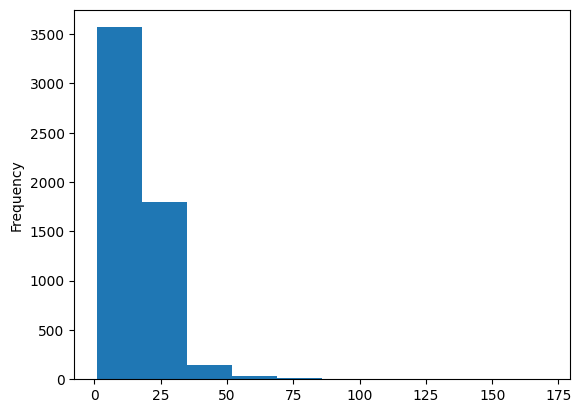

In [334]:
data['num_words'].plot.hist()

In [335]:
 max_tokens = 64

In [336]:
tokenizer = Tokenizer(num_words=max_tokens)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [337]:
len_tokens = [len(token_list) for token_list in X_train]

(array([3.344e+03, 9.740e+02, 9.900e+01, 2.800e+01, 3.000e+00, 8.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  8.8, 17.6, 26.4, 35.2, 44. , 52.8, 61.6, 70.4, 79.2, 88. ]),
 <BarContainer object of 10 artists>)

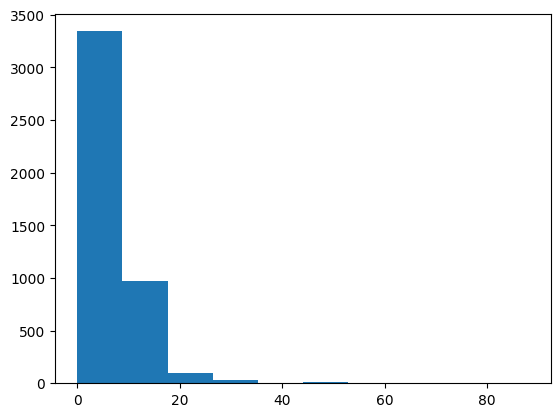

In [338]:
plt.hist(len_tokens)

In [339]:
maxlen=20

In [340]:
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [341]:
 X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((4457, 20), (1115, 20), (4457, 2), (1115, 2))

In [342]:
from keras.models import Sequential
import keras
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report

In [343]:
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# model.add(Dense(2, activation='softmax'))

In [344]:
model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.Precision(), keras.metrics.Recall()])

In [345]:
Y_train_binary = np.argmax(Y_train.values, axis=1)
Y_test_binary = np.argmax(Y_test.values, axis=1)

In [346]:
Y_train

,ham,spam
861,1,0
893,1,0
156,1,0
190,1,0
1631,1,0
...,...,...
5320,1,0
5433,1,0
4756,1,0
2791,0,1


In [347]:
Y_train_binary.shape

(4457,)

In [348]:
print(Y_train_binary[:100])  # Print the first 100 values


[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]


In [349]:
history = model.fit(X_train, Y_train_binary, epochs=10, batch_size=16)

Epoch 1/10
279/279 [==============================] - 2s 2ms/step - loss: 0.6007 - precision_11: 0.2290 - recall_11: 0.1289
Epoch 2/10
279/279 [==============================] - 1s 2ms/step - loss: 0.4041 - precision_11: 0.3655 - recall_11: 0.0865
Epoch 3/10
279/279 [==============================] - 1s 2ms/step - loss: 0.3654 - precision_11: 0.4597 - recall_11: 0.0930
Epoch 4/10
279/279 [==============================] - 1s 2ms/step - loss: 0.3481 - precision_11: 0.4519 - recall_11: 0.0767
Epoch 5/10
279/279 [==============================] - 1s 2ms/step - loss: 0.3354 - precision_11: 0.6207 - recall_11: 0.1175
Epoch 6/10
279/279 [==============================] - 1s 2ms/step - loss: 0.3252 - precision_11: 0.6404 - recall_11: 0.1191
Epoch 7/10
279/279 [==============================] - 1s 2ms/step - loss: 0.3178 - precision_11: 0.6923 - recall_11: 0.1321
Epoch 8/10
279/279 [==============================] - 1s 2ms/step - loss: 0.3105 - precision_11: 0.6761 - recall_11: 0.1566
Epoch 9/

In [350]:
 history.history

{'loss': [0.6006706357002258,
  0.40414249897003174,
  0.3654293119907379,
  0.3480699360370636,
  0.3354032039642334,
  0.32524433732032776,
  0.31779417395591736,
  0.31049686670303345,
  0.3100811541080475,
  0.3031494617462158],
 'precision_11': [0.2289855033159256,
  0.3655172288417816,
  0.45967742800712585,
  0.45192307233810425,
  0.6206896305084229,
  0.640350878238678,
  0.692307710647583,
  0.6760563254356384,
  0.658682644367218,
  0.699386477470398],
 'recall_11': [0.12887439131736755,
  0.08646003156900406,
  0.09298531711101532,
  0.07667210698127747,
  0.1174551397562027,
  0.11908645927906036,
  0.13213703036308289,
  0.15660685300827026,
  0.17944535613059998,
  0.18597063422203064]}

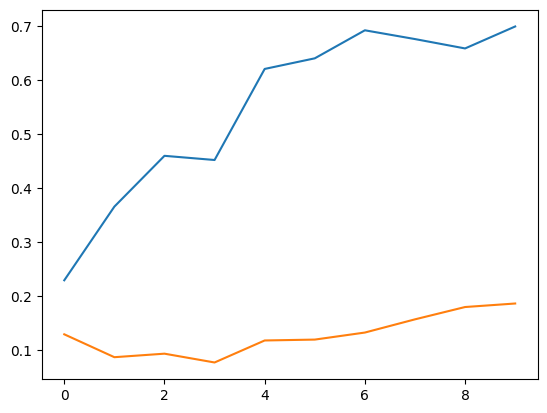

In [351]:
plt.plot(history.history['precision_11'])
plt.plot(history.history['recall_11'])
plt.show()

In [352]:
preds = model.predict(X_test)

35/35 [==============================] - 0s 2ms/step


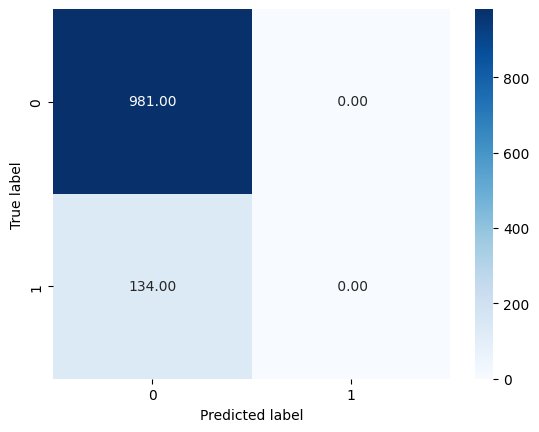

In [353]:
confmat = confusion_matrix(np.argmax(Y_test.values, axis=1), np.argmax(preds, axis=1))
sns.heatmap(confmat, annot=True, cmap='Blues', fmt='5.2f')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [354]:
print(classification_report(np.argmax(Y_test.values, axis=1), np.argmax(preds, axis=1)))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94       981
           1       0.00      0.00      0.00       134

    accuracy                           0.88      1115
   macro avg       0.44      0.50      0.47      1115
weighted avg       0.77      0.88      0.82      1115



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
